In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import math
import time
import openai
import torch

from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.patches import Rectangle
from pyvis.network import Network
from pyvis.network import Network
from gingerit.gingerit import GingerIt
from rapidfuzz.distance import Levenshtein

from transformers import AutoImageProcessor, AutoModelForObjectDetection
from PIL import Image, ImageDraw

### One function for each step in the pipeline

In [2]:
def get_ocr_data(json_file):
    with open(json_file) as fp:
        data = json.loads(fp.read())
    
    nodes = []

    for b in data['Blocks']:
        if b['BlockType'] == 'LINE' and (len(b['Text']) > 2):
            node = {'text': b['Text'], 
                    'left': b['Geometry']['BoundingBox']['Left'], 
                    'top': b['Geometry']['BoundingBox']['Top'],
                    'right': b['Geometry']['BoundingBox']['Left'] + b['Geometry']['BoundingBox']['Width'],
                    'bottom': b['Geometry']['BoundingBox']['Top'] + b['Geometry']['BoundingBox']['Height']}

            nodes.append(node)
    
    return pd.DataFrame(nodes)

In [3]:
def open_image(filename):
    
    img = cv2.imread(filename)
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
def threshold_image(image):
    
    img = image.copy()
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    mean_tone_value = np.mean(gray)
    
    #print(mean_tone_value)
    
    if mean_tone_value < 128:
        
        gray = 255 - gray
        mean_tone_value = np.mean(gray)
    
    threshold_value = int(mean_tone_value * 0.8)
    
    _, threshold = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    
    threshold = 1 - (threshold / 255.)
    
    return threshold
    

In [5]:
def set_bounding_boxes_in_pixels(df, img):
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    for i, row in df.iterrows():
         
        df.at[i, 'left']   = int(round(row['left'] * img_width))
        df.at[i, 'right']  = int(round(row['right'] * img_width))
        df.at[i, 'top']    = int(round(row['top'] * img_height))
        df.at[i, 'bottom'] = int(round(row['bottom'] * img_height))
        
    df['left']   = df['left'].astype(int)
    df['right']  = df['right'].astype(int)
    df['top']    = df['top'].astype(int)
    df['bottom'] = df['bottom'].astype(int)
    
    return df

In [6]:
def get_font_size(df):
    
    df['font_size'] = df.bottom - df.top
    
    df['font_size'] = (df['font_size'] - df['font_size'].mean()) / (df['font_size'].std() + 1e-6)
    
    df['font_size'] = (df['font_size'].apply(lambda x: round(x)) + 10).astype(int)
    
    return df

In [7]:
def substract_bounding_boxes(df, img, erotion_percent = 0):
    
    img_out = img.copy()

    for i, row in df.iterrows():
        
        width = row['right'] - row['left']
        erotion_width = int(round((width * erotion_percent) / 100))
        
        height = row['bottom'] - row['top']
        erotion_height = int(round((height * erotion_percent) / 100))
        

        img_out[ (row['top'] + erotion_height)  : (row['bottom'] - erotion_height), 
                 (row['left'] + erotion_width) : (row['right'] - erotion_width) ] = 0
    
    return img_out

In [8]:
def close_shape_gaps5(image, ocr,
                      dist_threshold_percent = 30, 
                      activation_lower_th = 40, 
                      activation_upper_th = 70):

    img = image.copy()
    img = (1-img) * 10

    kernel = np.ones((3, 3), np.uint8)
    kernel[1,1] = 10

    dst = cv2.filter2D(img,-1,kernel).astype(int)

    points_thr = np.where((dst > activation_lower_th) & (dst < activation_upper_th))

    points = []
    for p_i in range(len(points_thr[0])): 
        points.append([points_thr[0][p_i], points_thr[1][p_i]])

    points = np.stack(points, axis=0)

    nodes_points = []

    nodes_points.extend([[row.top, row.left] for i, row in ocr.iterrows()])
    nodes_points.extend([[row.top, row.right] for i, row in ocr.iterrows()])
    nodes_points.extend([[row.bottom, row.right] for i, row in ocr.iterrows()])
    nodes_points.extend([[row.bottom, row.left] for i, row in ocr.iterrows()])

    nodes_points   = np.array(nodes_points)
    dist_matrix    = euclidean_distances(points)
    max_bb_height  = (ocr.bottom - ocr.top).max()
    dist_threshold = int((max_bb_height * dist_threshold_percent)/100)

    below_th = np.where((dist_matrix < dist_threshold) & (dist_matrix > 0)) # zero is trivial distance, no need to fill any gap

    img_out = image.copy()

    for i in range(len(below_th[0])):

        p1 = points[below_th[0][i]]
        p2 = points[below_th[1][i]]

        dist_to_nodes = euclidean_distances(np.stack([p1, p2]), nodes_points)
        closest_node = np.argmin(dist_to_nodes) % len(ocr)

        closest_node_height = ocr.loc[closest_node, 'bottom'] - ocr.loc[closest_node, 'top']

        dist_threshold = int((closest_node_height * dist_threshold_percent)/100)

        if np.linalg.norm(p2-p1) < dist_threshold:

            cv2.line(img_out, [p1[1],p1[0]], [p2[1],p2[0]],  (1, 1, 1), thickness=1)
    
    return img_out

In [9]:
def stamp_bounding_boxes_on_image(df, img, erotion_percent = 10):
    
    img_out = img.copy()

    for i, row in df.iterrows():
        
        width = row['right'] - row['left']
        erotion_width = int(round((width * erotion_percent) / 100))
        
        height = row['bottom'] - row['top']
        erotion_height = int(round((height * erotion_percent) / 100))
        

        img_out[ (row['top'] + erotion_height)  : (row['bottom'] - erotion_height), 
                 (row['left'] + erotion_width) : (row['right'] - erotion_width) ] = 1
    
    return img_out

In [10]:
def get_filled_shapes(img):
    
    contours, tree = cv2.findContours(cv2.convertScaleAbs(img), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    img_out = np.zeros_like(img)

    for i, contour in enumerate(contours):
        cv2.drawContours(img_out, [contour], 0, (1, 1, 1), thickness=cv2.FILLED)
        
    return img_out

In [11]:
def get_masks(img, max_iter=10):
    

    kernel = np.ones((3, 3), np.uint8)

    img_eroded = [img.copy()]
    contours_iter = []

    for i in range(max_iter):
        contours, tree = cv2.findContours(cv2.convertScaleAbs(img_eroded[-1]), 
                                          cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours_iter.append(contours)
        img_eroded.append(cv2.erode(img_eroded[-1], kernel, iterations = 1))
    
    min_contours = len(contours_iter[-1])
    min_contours_iteration = len(contours_iter)-1

    for i in range(len(contours_iter)-1, -1, -1):
        if len(contours_iter[i]) > min_contours:
            min_contours_iteration = i+1
            break
            
            
    nodes_mask = img_eroded[min_contours_iteration]
    
    nodes_mask_dilated = cv2.dilate(nodes_mask, kernel, iterations=min_contours_iteration+1)
    edges_mask = np.maximum((img_eroded[0] - nodes_mask_dilated), 0)


    return nodes_mask, edges_mask

In [12]:
def get_edges_endpoints(edges_mask, min_edge_length_percentage = 3):
    
    final_edges = []
    
    min_edge_length_pixels = (min_edge_length_percentage / 100) * edges_mask.shape[0]

    contours, tree = cv2.findContours(cv2.convertScaleAbs(edges_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        
        c = max([contour], key=cv2.contourArea)
        
        extreme_points = []

        extreme_points.append(np.array(c[c[:, :, 0].argmin()][0]))
        extreme_points.append(np.array(c[c[:, :, 0].argmax()][0]))
        extreme_points.append(np.array(c[c[:, :, 1].argmin()][0]))
        extreme_points.append(np.array(c[c[:, :, 1].argmax()][0]))
        
        extreme_points = np.stack(extreme_points, axis=0)

        dist_mat = euclidean_distances(extreme_points)
        
        if np.max(dist_mat) > min_edge_length_pixels:
        
            ext_indeces = np.unravel_index(np.argmax(dist_mat), shape=dist_mat.shape)


            final_endpoints = [extreme_points[ext_indeces[0]], extreme_points[ext_indeces[1]]]

            final_edges.append(final_endpoints)


    return np.stack(final_edges)

In [13]:
def get_nodes(ocr, nodes_mask, threshold_iou = 0.8):
    
    df = ocr.copy()
    nodes_contours, tree = cv2.findContours(cv2.convertScaleAbs(nodes_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    
    for i, row in df.iterrows():

        area = (row['right'] - row['left']) * (row['bottom'] - row['top'])

        max_iou = 0
        max_iou_i_node = -1
        

        for i_node, contour in enumerate(nodes_contours):

            empty_img = np.zeros_like(nodes_mask)

            cv2.drawContours(empty_img, [contour], 0, (1, 1, 1), thickness=-1)

            intersection = empty_img[row['top']:row['bottom'], row['left']:row['right']].sum()

            iou = intersection / area

            if iou > max_iou:
                max_iou = iou
                max_iou_i_node = i_node

        if max_iou > threshold_iou:

            df.at[i, 'node_id'] = max_iou_i_node
            
    df['text'] = df.groupby('node_id')['text'].transform(lambda x: '\n'.join(x))
    df.drop_duplicates('text', inplace=True)

    df =df[df.node_id.notna()]
    df.node_id = df.node_id.astype(int)
    
    df.reset_index(drop=True, inplace=True)
    
    return df

In [14]:
def get_conections(nodes_df, edges_endpoints, img, dist_threshold_percentage = 5):
    
    nodes_contours = []
    nodes_ids = []
    
    for i, row in nodes_df.iterrows():
        
        img_out = np.zeros_like(img, dtype=np.uint16)
        
        img_out[ row.top : row.bottom, row.left : row.right ] = 1
        
        contour, tree = cv2.findContours(cv2.convertScaleAbs(img_out), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        assert len(contour) == 1
        
        nodes_contours.append(contour[0])
        nodes_ids.append(row.node_id)
        
    
    
    edges_endpoints = edges_endpoints.astype(np.uint16)

    connections = []

    dist_threshold_in_pixels = int((dist_threshold_percentage / 100) * img.shape[0])

    for edge in edges_endpoints:

        connection = [None, None]

        for i_endpoint, endpoint in enumerate(edge):

            min_dist_to_node = 9e3
            min_dist_node_n = -1

            for i_node, node in enumerate(nodes_contours):

                min_dist = cv2.pointPolygonTest(node, endpoint, True) * (-1)


                if min_dist < min_dist_to_node:
                    min_dist_to_node = min_dist
                    min_dist_node_n = nodes_ids[i_node]

            if min_dist_to_node < dist_threshold_in_pixels:

                connection[i_endpoint] = min_dist_node_n

        if connection[0] is not None and connection[1] is not None and connection[0] != connection[1]:
            connections.append(connection) 

    df = pd.DataFrame(connections, columns=['node a', 'node b'])

    froze_set = set([frozenset([row['node a'], row['node b']]) for i, row in df.iterrows()])

    df = pd.DataFrame(froze_set, columns=['node a', 'node b'])
    
    return df

In [15]:
def filter_image_nodes_from_annotated_df(df):
    
    df = df[df.text.apply(lambda x: x.startswith('image') == False)]
    
    if 'type' in df.columns:
        return df[df.type != 'image']
    else:
        return df

In [16]:
def join_close_nodes(ocr, vertical_distance_threshold_percent=25, horizontal_distance_threshold_percent=50):
    
    df = ocr.copy()
    
    while True:

        to_add = []
        to_remove = []

        flag_updates_made = False

        for i,row_a in df.iterrows():
            for j,row_b in df.iterrows():

                row_a_height = row_a.bottom - row_a.top
                row_b_height = row_b.bottom - row_b.top

                row_a_width = row_a.right - row_a.left
                row_b_width = row_b.right - row_b.left

                mean_height = (row_a_height + row_b_height) / 2
                mean_width  = (row_a_width + row_b_width) / 2

                vertical_distance_threshold_pixels   = (vertical_distance_threshold_percent / 100) * mean_height
                horizontal_distance_threshold_pixels = (horizontal_distance_threshold_percent / 100) * mean_width

                if (j > i and 
                    abs(row_b.top - row_a.bottom) < vertical_distance_threshold_pixels and
                    abs(row_b.left - row_a.left) < horizontal_distance_threshold_pixels):
                    
                    df.at[i, 'text'] = row_a.text + ' ' + row_b.text
                    df.at[i, 'bottom'] = row_b.bottom
                    df.at[i, 'left'] = min(row_a.left, row_b.left)
                    df.at[i, 'right'] = max(row_a.right, row_b.right)
                    df.at[i, 'font_size'] = (row_a.font_size + row_b.font_size) / 2

                    df = df.drop(j, axis=0)
                    df.reset_index(drop=True, inplace=True)

                    flag_updates_made = True
                   
                    break

            if flag_updates_made:
                break
        
        if flag_updates_made == False:
            break
    
    return df

In [17]:
parser = GingerIt()

def spellcheck2(text):
    text = text.replace('&', 'and')
    res = parser.parse(text)
    output = res['result']
    output = output.replace(' and ', ' & ')
    return output

In [18]:
def pair_nodes_with_closest_annotations(pred_df, annotated_df, dist_threshold = 0.35):
    
    predicted_df = pred_df.copy()
    
    predicted_df.insert(column='closest_ann_text', loc=1, value=None)
    predicted_df.insert(column='closest_ann_node_id', loc=len(predicted_df.columns), value=-1)
    predicted_df.insert(column='closest_ann_dist', loc=len(predicted_df.columns), value=1)
    
    for i, row_a in predicted_df.iterrows():
        
        min_dist = dist_threshold
        min_dist_text = None
        min_dist_node_id = -1
        
        for j, row_b in annotated_df.iterrows():
            
            dist = Levenshtein.normalized_distance(row_a.text, row_b.text)
            if dist < min_dist:
                min_dist = dist
                min_dist_text = row_b.text
                min_dist_node_id = row_b.node_id
        
        predicted_df.at[i, 'closest_ann_text']    = min_dist_text
        predicted_df.at[i, 'closest_ann_node_id'] = min_dist_node_id
        predicted_df.at[i, 'closest_ann_dist']    = min_dist
    
    predicted_df = predicted_df[predicted_df.closest_ann_dist < dist_threshold]
    
    return predicted_df

# 

## functions to calculate metrics

In [19]:
def get_nodes_metrics(ann_nodes, nodes_df):
    
    nodes_df = pair_nodes_with_closest_annotations(nodes_df.copy(), ann_nodes)
    
    predictions = set(nodes_df.closest_ann_text.apply(lambda x: x.lower()).tolist())
    annotations = set(ann_nodes.text.apply(lambda x: x.lower()).tolist())
    
    tp = annotations & predictions
    
    precision = len(tp) / (len(predictions) + 1e-6)
    recall    = len(tp) / (len(annotations) + 1e-6)
    f1        = (2 * precision * recall) / (precision+recall + 1e-6)
    
    return f1, precision, recall

In [20]:
def show_results(nodes_f1, nodes_pr, nodes_re):
    
    sns.set_theme()

    fig, ax = plt.subplots(figsize=(10,4))

    ax.plot(range(1,len(nodes_f1)+1), nodes_f1, label='F1')
    ax.plot(range(1,len(nodes_pr)+1), nodes_pr, label='Precision')
    ax.plot(range(1,len(nodes_re)+1), nodes_re, label='Recall')
    ax.set_ylim(0,1)
    ax.set_title('Drawing retrieval')
    ax.legend()

    print(f'Mean F1-score for node retrieval: {np.mean(nodes_f1)}')


    plt.show()

# 

## get all annotated examples

In [21]:
main_folder = '../annotated_examples'

ann_examples = sorted(os.listdir(main_folder))

n_examples = len(ann_examples)

print(f'number of annotated examples: {n_examples}')

number of annotated examples: 21


In [22]:
to_exclude_to_time_complexity = ['Hipshot for inflation',
                                 'IMG_0300-1664016398.2217-scaled',
                                 'Mathematics Map',
                                 'erythrocytes L1_2']

#

# new baseline

In [23]:
drawing_checkpoint = "models/drawing"

drawing_image_processor = AutoImageProcessor.from_pretrained(drawing_checkpoint)
drawing_model = AutoModelForObjectDetection.from_pretrained(drawing_checkpoint)


def get_drawing_predictions(image, threshold=0.1):

    img     = Image.fromarray(image)
    inputs  = drawing_image_processor(images=img, return_tensors="pt")
    outputs = drawing_model(**inputs)
    
    target_sizes = torch.tensor([img.size[::-1]])
    return drawing_image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
# def get_drawing_predictions(image, threshold=0.1):

#     img     = Image.fromarray(image)
#     inputs  = drawing_image_processor(images=img, return_tensors="pt")
#     outputs = drawing_model(**inputs)
    
#     target_sizes = torch.tensor([img.size[::-1]])
#     results = drawing_image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0] 
#     draw = ImageDraw.Draw(image)
#     for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#         box = [round(i, 2) for i in box.tolist()]
#         print(
#                 f"Detected {model.config.id2label[label.item()]} with confidence "
#                 f"{round(score.item(), 3)} at location {box}"
#         )
#         draw.rectangle(box, outline="red", width=1)
    
#     return image

In [24]:
def get_datasets(annotations_file, images_folder):
    
    with open(annotations_file) as fp:
        annotations = json.loads(fp.read())
    
    elements = []
    
    for i, image_description in enumerate(annotations['images']):
    
        img = Image.open(os.path.join(images_folder, image_description['file_name']))
    
        objects = {'id':[], 
                   'area': [],
                   'bbox': [],
                   'category': []}
        
        for j, ann_description in enumerate(annotations['annotations']):
    
            if ann_description['image_id'] == image_description['id']:
    
                objects['id'].append(ann_description['id'])
                objects['area'].append(ann_description['area'])
                objects['bbox'].append(ann_description['bbox'])
                objects['category'].append(ann_description['category_id'])
        
        
        el = {'image_id': image_description['id'],
              'image': img,
              'width': image_description['width'],
              'height': image_description['height'],
              'objects': objects
        }
    
        elements.append(el)

    return Dataset.from_list(elements)

In [25]:
def compute_iou(box1, box2):
    """Compute Intersection over Union of two boxes."""
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2
    
    xi1, yi1, xi2, yi2 = max(x1, x1_), max(y1, y1_), min(x2, x2_), min(y2, y2_)
    
    intersection = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    
    area_box1 = (x2 - x1) * (y2 - y1)
    area_box2 = (x2_ - x1_) * (y2_ - y1_)
    
    union = area_box1 + area_box2 - intersection
    
    return intersection / union if union > 0 else 0

def non_maximum_suppression(detections, iou_threshold=0.5):
    """Apply NMS on detections and return filtered detections."""
    detections = sorted(detections, key=lambda x: x['Confidence Score'], reverse=True)
    keep = []
    while detections:
        max_score_det = detections.pop(0)
        keep.append(max_score_det)
        detections = [
            det for det in detections
            if compute_iou(max_score_det['Location'], det['Location']) < iou_threshold
        ]
    return keep

In [40]:
import pandas as pd

def show_predictions(image, threshold=0.9):
    
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
    
    draw = ImageDraw.Draw(image)
    
    # List to collect detection details
    detections = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        detection_info = {
            'Label': model.config.id2label[label.item()],
            'Confidence Score': round(score.item(), 3),
            'Location': box
        }
        detections.append(detection_info)
        
        print(
            f"Detected {detection_info['Label']} with confidence "
            f"{detection_info['Confidence Score']} at location {detection_info['Location']}"
        )
        draw.rectangle(box, outline="red", width=1)

    
    # Convert the list of dictionaries to a DataFrame and save as a CSV file
    detections_df = pd.DataFrame(detections)

    return image, detections_df

In [41]:
# import json

# # 打开文件并读取其内容
# with open(test_annotations_file, 'r') as file:
#     data = json.load(file)

# # 使用data变量处理JSON内容，例如提取annotations中image_id为0的所有bbox
# gt_boxes = [list(map(round, ann["bbox"])) for ann in data["annotations"] if ann["image_id"] == 0]



In [92]:
from datasets import Dataset
test_images_folder = 'data/real_data/real_test_drawing/'
test_annotations_file = 'data/real_data/real_test_drawing/result.json'
image_processor = AutoImageProcessor.from_pretrained(drawing_checkpoint)
model = AutoModelForObjectDetection.from_pretrained(drawing_checkpoint)

dataset_test = get_datasets(test_annotations_file, test_images_folder)
image_test,df_test =  show_predictions(dataset_test[8]['image'], 0.5)

ValueError: Unable to infer channel dimension format

In [84]:
df_test

""


In [47]:
# pred_boxes = df_test['Location'].tolist()


In [59]:
def convert_to_center_format(box):
    xmin, ymin, xmax, ymax = box
    x_center = xmin
    y_center = ymin
    width = xmax - xmin
    height = ymax - ymin
    return [x_center, y_center, width, height]



In [61]:
def iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    
    intersection_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area
    
    return intersection_area / union_area




In [65]:
iou_threshold = 0.3
# matches = 0

# for pred_box in pred_boxes_int:
#     best_iou = 0
#     for gt_box in gt_boxes:
#         current_iou = iou(pred_box, gt_box)
#         best_iou = max(best_iou, current_iou)
    
#     if best_iou > iou_threshold:
#         matches += 1

# precision = matches / len(pred_boxes_int)
# recall = matches / len(gt_boxes)

# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")

In [93]:
def compute_precision_recall_for_image(image_id, threshold=0.5):
    gt_boxes = [list(map(round, ann["bbox"])) for ann in data["annotations"] if ann["image_id"] == image_id]
    image_test, df_test = show_predictions(dataset_test[image_id]['image'], threshold)
    

    if 'Location' not in df_test.columns:
        return None

    pred_boxes = df_test['Location'].tolist()

    center_format_boxes = [convert_to_center_format(box) for box in pred_boxes]
    pred_boxes_int = [[int(coordinate) for coordinate in box] for box in center_format_boxes]

    matches = 0
    for pred_box in pred_boxes_int:
        best_iou = 0
        for gt_box in gt_boxes:
            current_iou = iou(pred_box, gt_box)
            best_iou = max(best_iou, current_iou)

        if best_iou > iou_threshold:
            matches += 1

    precision = matches / len(pred_boxes_int) if pred_boxes_int else 0
    recall = matches / len(gt_boxes) if gt_boxes else 0

    return precision, recall

image_ids = range(len(dataset_test))  # 
all_precisions = []
all_recalls = []

for image_id in image_ids:
    if image_id in [0,1,3,6,8]:
        continue
    result = compute_precision_recall_for_image(image_id)
    
    if result is None:
        continue  # 

    precision, recall = result
    all_precisions.append(precision)
    all_recalls.append(recall)
    # 
    print(f"Processed Image ID: {dataset_test[image_id]['image_id']}")
print(f"All Precisions: {all_precisions}")
print(f"All Recalls: {all_recalls}")


Detected drawing with confidence 0.687 at location [551.8, 352.95, 580.29, 377.01]
Detected drawing with confidence 0.97 at location [195.28, 104.95, 231.56, 137.44]
Detected drawing with confidence 0.557 at location [467.01, 452.29, 498.91, 479.58]
Detected drawing with confidence 0.719 at location [645.03, 322.2, 716.34, 331.8]
Detected drawing with confidence 0.778 at location [158.28, 274.28, 188.81, 305.28]
Detected drawing with confidence 0.688 at location [400.09, 352.83, 441.11, 378.78]
Detected drawing with confidence 0.928 at location [533.28, 633.78, 564.71, 657.77]
Detected drawing with confidence 0.626 at location [168.04, 251.38, 200.74, 278.76]
Detected drawing with confidence 0.817 at location [562.45, 551.01, 643.27, 625.75]
Detected drawing with confidence 0.726 at location [409.27, 439.68, 508.24, 490.68]
Detected drawing with confidence 0.538 at location [850.18, 43.89, 887.77, 64.79]
Detected drawing with confidence 0.948 at location [187.68, 254.1, 248.98, 296.88]

In [94]:
all_f1_scores = []
for precision, recall in zip(all_precisions, all_recalls):
    if precision + recall != 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    all_f1_scores.append(f1)

print(f"All F1 Scores: {all_f1_scores}")

All F1 Scores: [0.4358974358974359, 0.5714285714285715, 0.6666666666666666, 0.36363636363636365]


Mean F1-score for node retrieval: 0.5094072594072594


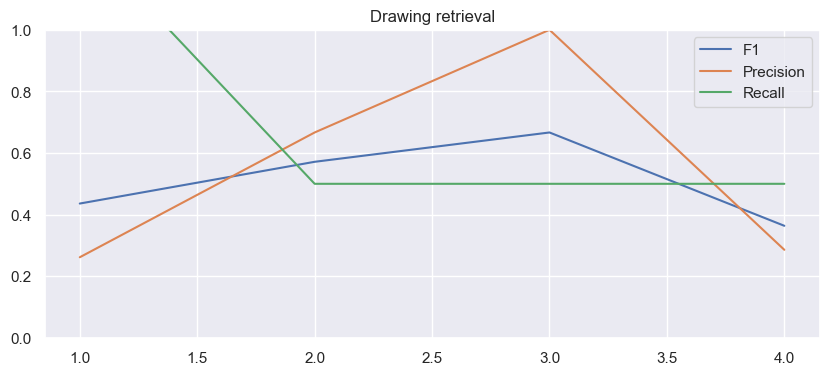

In [95]:
show_results(all_f1_scores, all_precisions, all_recalls)

In [97]:
# import cv2
# import matplotlib.pyplot as plt

# # 读取图片
# image_path = r"C:\Users\Aliphraim\Desktop\edge_feature\federico\ML_piplie\yolo_mini_yizhe\notebooks\data\real_data\real_test_nodes\images\0510e541-0f349bf1-erythrocytes_L1_2.jpg"
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 

# # 绘制 gt_boxes
# for box in gt_boxes:
#     x, y, w, h = box
#     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # 

# # 绘制 pred_boxes
# for box in pred_boxes_int:
#     x, y, w, h = [int(i) for i in box]
#     cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # 

# # 使用matplotlib显示图片
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# plt.axis('off')
# plt.show()
